In [1]:
# Import the required external module(s)
import matplotlib.pyplot as plt
import microImage as mim

# Import the functions from the module
from TPHelper import startSession, startManager

## Step 0 - (Pre-step) - Opening an image using microImage
We use here the [microImage](https://github.com/vivien-walter/microImage) plug-in to open an image in an array that can be easily read by TPHelper

In [2]:
test_file = '/path/to/folder/test_image.tif'
imageArray = mim.openImage(test_file)

Eventually contrast or background correct the image for better use

In [3]:
imageArray = mim.backgroundCorrection(imageArray, signed_bits=True, average='median')
correctedArray = mim.contrastCorrection(imageArray, min=600, max=1200)

Check the image to be processed

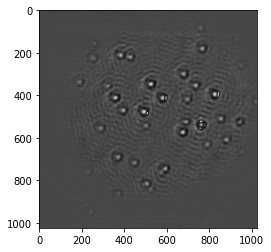

In [4]:
plt.imshow(correctedArray[0], cmap='gray')

## Step 1 - Extraction of the trajectory
We will see here how to create an instance of the class TrackingSession

### Start a session to track particles in the image sequence

In [5]:
# We load directly the array in the class to avoid calling it all the time
tpSettings = startSession(array=imageArray, diameter=41)

In [6]:
# Display all the properties
tpSettings.showParameters()

Object properties:
------------------
self.diameter: 41	self.minmass: None
self.maxsize: None	self.separation: None
self.percentile: 64	self.invert: False

Filter properties:
------------------
self.noise_size: 1	self.smoothing_size: None
self.threshold: None	self.preprocess: True
self.topn: None

Other parameters:
-----------------
self.characterize: True	self.engine: auto

Trajectory parameters:
-----------------
self.search_range: 41	self.memory: 0
self.adaptive_stop: None	self.adaptive_step: 0.95
self.neighbor_strategy: None	self.link_strategy: None
self.filter_stubs: None



### Edit some of the attributes for TrackPy

In [7]:
tpSettings.memory = 3
tpSettings.filter_stubs = 40

### Process all the frames of the sequence

In [ ]:
trajectory = tpSettings.batch(filter=True, store=True)

Frame 34: 143 features


### Display the trajectory collected

In [ ]:
# We use here the contrast corrected array for the image to display
tpSettings.preview(array=correctedArray)

### Save the settings in a file

In [ ]:
tpSettings.save(file_name='test_settings.json')

## Step 2 - Edit the trajectory to remove useless tracks and save it
Now that the trajectory has been extracted, we will use the class TrackManager to edit it

### Start the track manager

In [ ]:
# We load directly here the contrast corrected array to make display easier
tpManager = startManager(trajectory, array=correctedArray)

### Display a specific track

In [ ]:
# List all tracks and display the list
tpManager.listTracks()

In [ ]:
# Display a specific track
tpManager.show(track_ids=[40])

### Remove a track

In [ ]:
# Remove the useless track
tpManager.remove(40)

In [ ]:
# Reset the particle index
tpManager.resetID()
tpManager.listTracks()

### Split a track

In [ ]:
# Split the 6th track after the 11th frame 
tpManager.split(5,10)

### Merge two tracks into one

In [ ]:
# Merge two tracks
tpManager.merge(10,12)

### Save the resulting trajectory into a XML file

In [ ]:
# Save the trajectory in a XML file
tpManager.save(file_name='test_trajectory.xml', track_ids=None)